In [ ]:
library(glmnet)
library(survival)
library(Hmisc)
library(readxl)
library(pec)
library(randomForestSRC)
library(ggRandomForests)
library(caret)
library(pec)
library(plotly)

In [5]:
# The dataset must have a Status column with values of 0 or 1 that tells if the corresponding patient y is indicative of a 
# failure time or right censoring time and a Survival Time column (OS).

train <- data.frame(read_excel("Data_clean.agegr.trn.xlsx"))
xtrn <- as.matrix(train[,5:1031],use.names=FALSE)
ytrn <- Surv(train$OS, train$Status.OS)

test <- data.frame(read_excel("Data_clean.agegr.tst.xlsx"))
xtst<- as.matrix(test[,5:1031], use.names=FALSE)
ytst <- Surv(test$OS, test$Status.OS)

In [6]:
head(train,3)
dim(train)

id,OS,Status.OS,Grade,Age,original_shape_Volume,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_Sphericity,original_shape_SphericalDisproportion,...,wavelet.LLL_gldm_DependenceNonUniformityNormalized,wavelet.LLL_gldm_GrayLevelVariance,wavelet.LLL_gldm_DependenceVariance,wavelet.LLL_gldm_DependenceEntropy,wavelet.LLL_gldm_LowGrayLevelEmphasis,wavelet.LLL_gldm_HighGrayLevelEmphasis,wavelet.LLL_gldm_SmallDependenceLowGrayLevelEmphasis,wavelet.LLL_gldm_SmallDependenceHighGrayLevelEmphasis,wavelet.LLL_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet.LLL_gldm_LargeDependenceHighGrayLevelEmphasis
178,74.27727,0,1,34.3,564678,54584.266,0.09666441,0.6052720,1.652150,...,0.3677048,391.20157,0.8905756,7.950018,0.000778387,2992.6210,0.000435395,1897.68872,0.003600709,10273.13
6,27.66097,0,2,73.0,16227,3718.967,0.22918391,0.8334648,1.199811,...,0.4096528,232.08012,0.8068582,6.986512,0.002899917,2019.3577,0.002575654,1259.47201,0.004933955,7404.04
110,51.93824,1,2,46.4,264384,26020.241,0.09841836,0.7655900,1.306182,...,0.1362766,44.90592,5.8744439,7.658338,0.003697050,522.8409,0.001231636,84.01699,0.053951321,13837.87


[1]  165 1031

## Check that the train/test split is balanced regarding the Grade and Status columns

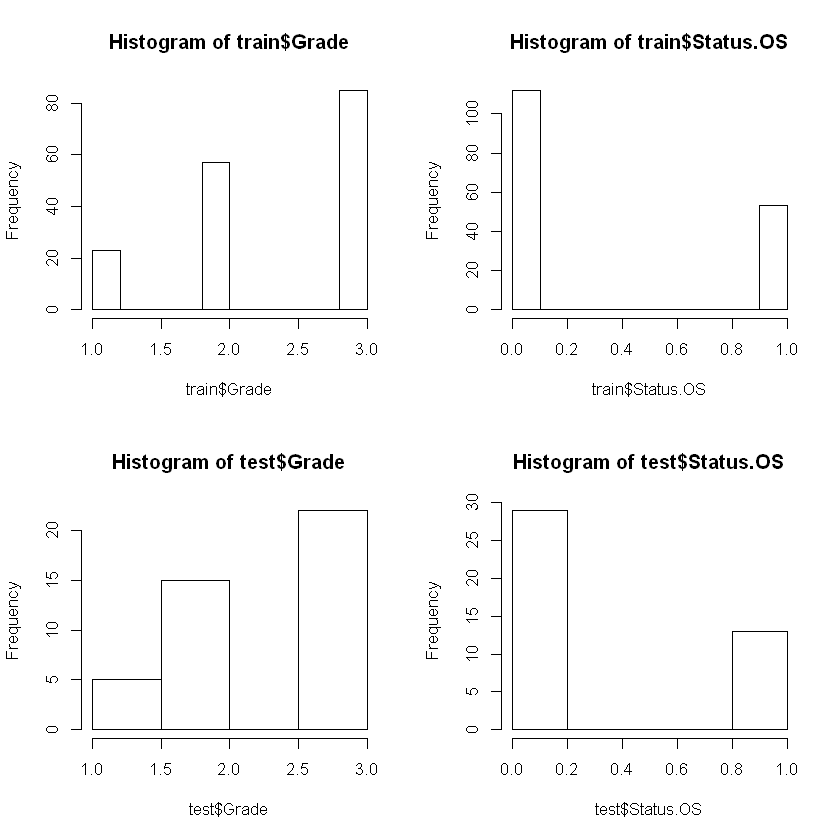

In [7]:
par(mfrow=c(2,2))
hist(train$Grade)
hist(train$Status.OS)
hist(test$Grade)
hist(test$Status.OS)

## Lasso-Cox regression

Since the number of features is much higher compared to the number of observations, a variable selection approach was needed.

Call the glmnet function to fit with the lasso penalty (α = 1)

In [8]:
cox <- glmnet(xtrn, ytrn, family="cox", alpha=1)

## Visualize the coefficients by executing the plot function

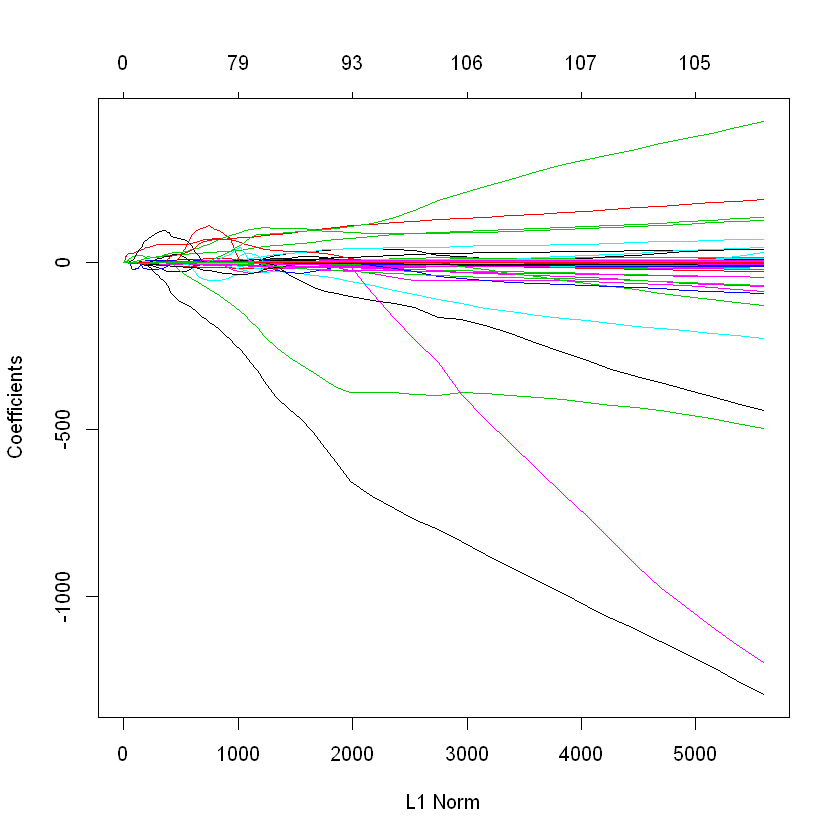

In [9]:
plot(cox)

Each curve corresponds to a variable. It shows the path of its coefficient against the ℓ1-norm of the whole coefficient vector at as λ varies. The axis above indicates the number of nonzero coefficients at the current λ, which is the effective degrees of freedom (df) for the lasso.  

https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html

The function glmnet returns a sequence of models for the users to choose from. 
The function cv.glmnet does cross validation and selects the best model.

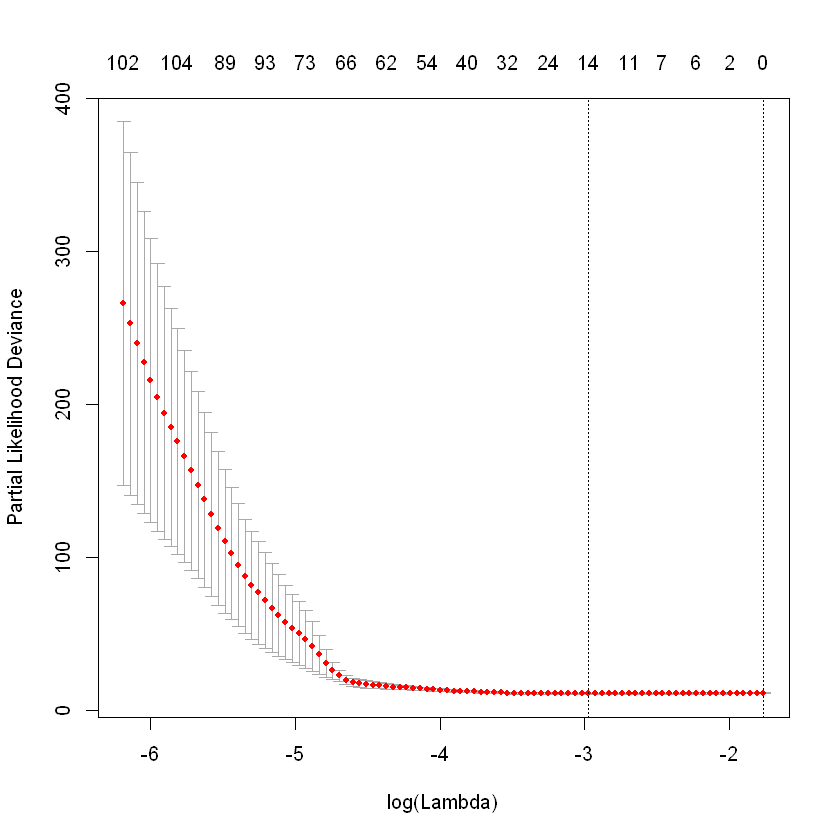

In [10]:
cv.cox <- cv.glmnet(xtrn, ytrn, family="cox", alpha=1)
plot(cv.cox)

The left vertical line in the plot shows where the CV-error curve hits its
minimum. The right vertical line shows the most regularized model with
CV-error within 1 standard deviation of the minimum. 

## Compute the Concordance Index for Lasso-Cox

This metric is needed in order to compare the models between them.

lambda.min is the optimal value of the regularization parameter, that gives the minimum negative log of the partial likelihood (that we want to penalize)

In [11]:
pred.cox<- predict(cox, newx = xtst, type = "response", s = cv.cox$lambda.min)
cindex<- rcorr.cens(pred.cox*-1, ytst)
cindex

C Index            Dxy           S.D.              n        missing 
     0.7065527      0.4131054      0.1585380     42.0000000      0.0000000 
    uncensored Relevant Pairs     Concordant      Uncertain 
    13.0000000    702.0000000    496.0000000   1020.0000000

## Get the variables selected by Lasso

The Coefficients contain the p length coefficient vector
of the solution corresponding to λ =cv.fit$lambda.min

In [12]:
Coefficients <- coef(cox, s = cv.cox$lambda.min)  
Active.Index <- which(Coefficients != 0)
Active.Coefficients <- Coefficients[Active.Index]
Active.Index
names(train[,Active.Index+4])
Active.Coefficients

[1]   1   5  54 237 262 355 694 757 810 858 878 946 958 998

[1] "Age"                                                     
 [2] "original_shape_Sphericity"                               
 [3] "original_glcm_MaximumProbability"                        
 [4] "log.sigma.5.0.mm.3D_glcm_InverseVariance"                
 [5] "log.sigma.5.0.mm.3D_glszm_LargeAreaHighGrayLevelEmphasis"
 [6] "wavelet.HHH_glszm_LargeAreaLowGrayLevelEmphasis"         
 [7] "wavelet.LHH_glcm_Idmn"                                   
 [8] "wavelet.LHL_firstorder_Kurtosis"                         
 [9] "wavelet.LHL_glszm_GrayLevelNonUniformityNormalized"      
[10] "wavelet.LLH_firstorder_Skewness"                         
[11] "wavelet.LLH_glcm_Idmn"                                   
[12] "wavelet.LLL_firstorder_Minimum"                          
[13] "wavelet.LLL_glcm_ClusterShade"                           
[14] "wavelet.LLL_glszm_LargeAreaHighGrayLevelEmphasis"

[1]  1.729262e-02 -1.282491e+00 -3.549889e+00  2.844229e-01  1.349519e-08
 [6] -1.831134e-06  2.657453e+01  5.476100e-02  9.578104e+00  2.958921e-01
[11]  8.509569e-01 -4.023149e-04 -1.019040e-06 -2.405168e-08

## Random Survival Forest

Train a Random Survival Forest using the features selected by lasso regression. 

In [13]:
df<-train[,Active.Index+4]
y<-train[,2:3]
dff<-cbind(y,df)


In [14]:
model <- rfsrc(Surv(OS,Status.OS) ~ ., dff,
                    nsplit = 10, na.action = "na.omit",
                    importance = FALSE,ntree = 120, nodesize = 3, block.size = 2,
                    splitrule="random")
print(model)


                         Sample size: 165
                    Number of deaths: 53
                     Number of trees: 120
           Forest terminal node size: 3
       Average no. of terminal nodes: 46.625
No. of variables tried at each split: 4
              Total no. of variables: 14
                            Analysis: RSF
                              Family: surv
                      Splitting rule: random
                          Error rate: 28.3%



## Get predictions on test set

The c-index is computed as 1-test set error rate

In [15]:

pred<- predict(model, newdata = test,
                     na.action = "na.omit",importance=TRUE)

print(pred)

  Sample size of test (predict) data: 42
       Number of deaths in test data: 13
                Number of grow trees: 120
  Average no. of grow terminal nodes: 46.625
         Total no. of grow variables: 14
                            Analysis: RSF
                              Family: surv
                 Test set error rate: 37.89%



In [22]:
# Check the Grading of the tumors and select 2 subjects, one with Grade 1 and one with Grade 3.

which(test$Grade==3)
which(test$Grade==1)

[1]  3  4  6  7  9 10 12 14 15 18 22 23 24 26 27 28 29 31 32 34 37 42

[1]  2 17 21 25 30

## Plot Survival Functions for predictions

In [38]:
p1 <- plot_ly(data=test, y = pred$survival[30,], name = 'Patient with Grade 1', type = 'scatter', mode = 'lines',line = list(color= "#008B8B")) %>%
  add_trace(y = pred$survival[37,], name = 'Patient with Grade 3', mode = 'lines',line=list(color= "#F08080"))%>%layout(title = "Estimated Survival functions",
                                                                                                                   xaxis = list(title = "Time"),
                                                                                                                   yaxis = list (title = "Survival probability"))



![Survival](SURV.png)

In [40]:
p2 <- plot_ly(data=test, y = pred$chf[30,], name = 'Patient with Grade 1', type = 'scatter', mode = 'lines',line = list(color= "#008B8B")) %>%
  add_trace(y = pred$chf[37,], name = 'Patient with Grade 3', mode = 'lines',line=list(color= "#F08080"))%>%layout(title = "Estimated Cumulative Hazard functions",
                                                                                     xaxis = list(title = "Time"),
                                                                                     yaxis = list (title = "Estimated CHF"))

![CHF](CHF.png)

## Plot the variable importance 

Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'NULL'"Warning message in gg_vimp.rfsrc(model):
"rfsrc object does not contain VIMP information. Calculating..."

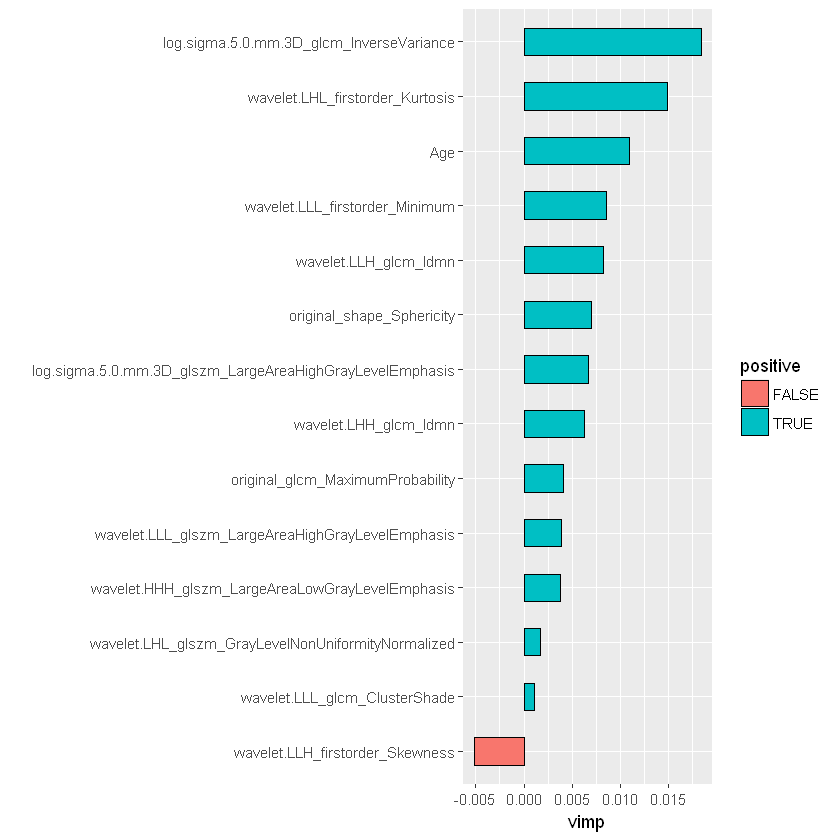

In [20]:
imp.rsf <- sort(model$importance, decreasing = T)
plot(gg_vimp(model))